In [24]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.distributions as dists
import numpy as np
import helper.wideresnet as wrn
import helper.dataloaders as dl
from helper import util
from helper.calibration_gp_utils import predict, gp_calibration_eval
from netcal.metrics import ECE

from laplace import Laplace

In [2]:
np.random.seed(7777)
torch.manual_seed(7777)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
print(torch.has_mps)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

False
True
1
0
NVIDIA GeForce GTX 1080 Ti


## 1) init

### data

In [21]:
train_loader = dl.CIFAR10(train=True)
test_loader = dl.CIFAR10(train=False)
targets = torch.cat([y for x, y in test_loader], dim=0).cpu()

Files already downloaded and verified
Files already downloaded and verified


### model

In [22]:
# The model is a standard WideResNet 16-4
# Taken as is from https://github.com/hendrycks/outlier-exposure
model = wrn.WideResNet(16, 4, num_classes=10).cuda().eval()
# print( sum(p.numel() for p in model.parameters()))

util.download_pretrained_model()
model.load_state_dict(torch.load('./temp/CIFAR10_plain.pt'))

<All keys matched successfully>

## 2) baselines

### MAP

In [23]:
probs_map = predict(test_loader, model, laplace=False)
acc_map = (probs_map.argmax(-1) == targets).float().mean()
ece_map = ECE(bins=15).measure(probs_map.numpy(), targets.numpy())
nll_map = -dists.Categorical(probs_map).log_prob(targets).mean()

print(f'[MAP] Acc.: {acc_map:.1%}; ECE: {ece_map:.1%}; NLL: {nll_map:.3}')
MAP_METRICS = {"acc": acc_map, "ece": ece_map, "nll": nll_map}

[MAP] Acc.: 94.8%; ECE: 2.0%; NLL: 0.172


### Parametric Laplace

In [28]:
la = Laplace(model, 'classification',
             subset_of_weights='last_layer',
             hessian_structure='kron')
la.fit(train_loader)
la.optimize_prior_precision(method='marglik')

probs_laplace = predict(test_loader, la, laplace=True)
acc_laplace = (probs_laplace.argmax(-1) == targets).float().mean()
ece_laplace = ECE(bins=15).measure(probs_laplace.numpy(), targets.numpy())
nll_laplace = -dists.Categorical(probs_laplace).log_prob(targets).mean()

print(f'[Laplace] Acc.: {acc_laplace:.1%}; ECE: {ece_laplace:.1%}; NLL: {nll_laplace:.3}')
PARAM_LAPLACE_METRICS = {"acc": acc_laplace, "ece": ece_laplace, "nll": nll_laplace}

[Laplace] Acc.: 94.8%; ECE: 0.8%; NLL: 0.157


## 3) Functional Laplace (GP)

In [7]:
metrics_gp = gp_calibration_eval(model=model, train_loader=train_loader, test_loader=test_loader)

10 0
[Laplace] Acc.: 94.8%; ECE: 1.6%; NLL: 0.166


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


10 1
[Laplace] Acc.: 94.8%; ECE: 1.7%; NLL: 0.166


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


10 2
[Laplace] Acc.: 94.8%; ECE: 1.7%; NLL: 0.166


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


10 3
[Laplace] Acc.: 94.9%; ECE: 1.6%; NLL: 0.166


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


10 4
[Laplace] Acc.: 94.9%; ECE: 1.6%; NLL: 0.166


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


50 0
[Laplace] Acc.: 94.8%; ECE: 1.1%; NLL: 0.159


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


50 1
[Laplace] Acc.: 94.8%; ECE: 1.1%; NLL: 0.159


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


50 2
[Laplace] Acc.: 94.9%; ECE: 1.1%; NLL: 0.159


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


50 3
[Laplace] Acc.: 94.8%; ECE: 1.1%; NLL: 0.159


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


50 4
[Laplace] Acc.: 94.8%; ECE: 1.1%; NLL: 0.159


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


100 0
[Laplace] Acc.: 94.9%; ECE: 0.9%; NLL: 0.158


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


100 1
[Laplace] Acc.: 94.8%; ECE: 0.8%; NLL: 0.157


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,
Traceback (most recent call last):
  File "/home/metod/miniconda3/envs/laplace/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/metod/miniconda3/envs/laplace/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/metod/miniconda3/envs/laplace/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/metod/miniconda3/envs/laplace/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/metod/miniconda3/envs/laplace/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)


100 2
[Laplace] Acc.: 94.8%; ECE: 0.6%; NLL: 0.157


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


100 3
[Laplace] Acc.: 94.9%; ECE: 0.5%; NLL: 0.157


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


100 4
[Laplace] Acc.: 94.9%; ECE: 0.5%; NLL: 0.159


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


300 0
[Laplace] Acc.: 94.9%; ECE: 1.5%; NLL: 0.165


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


300 1
[Laplace] Acc.: 94.9%; ECE: 1.7%; NLL: 0.168


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


300 2
[Laplace] Acc.: 94.8%; ECE: 1.9%; NLL: 0.17


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


300 3
[Laplace] Acc.: 94.9%; ECE: 1.7%; NLL: 0.168


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


300 4
[Laplace] Acc.: 94.8%; ECE: 1.8%; NLL: 0.169


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


500 0
[Laplace] Acc.: 94.8%; ECE: 1.8%; NLL: 0.168


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


500 1
[Laplace] Acc.: 94.8%; ECE: 1.7%; NLL: 0.167


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


500 2
[Laplace] Acc.: 94.9%; ECE: 1.8%; NLL: 0.168


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


500 3
[Laplace] Acc.: 94.8%; ECE: 1.8%; NLL: 0.169


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


500 4
[Laplace] Acc.: 94.8%; ECE: 1.8%; NLL: 0.169


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


1000 0
[Laplace] Acc.: 94.8%; ECE: 1.7%; NLL: 0.167


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


1000 1
[Laplace] Acc.: 94.9%; ECE: 1.7%; NLL: 0.167


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


1000 2
[Laplace] Acc.: 94.8%; ECE: 1.7%; NLL: 0.167


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


1000 3
[Laplace] Acc.: 94.8%; ECE: 1.6%; NLL: 0.165


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


1000 4
[Laplace] Acc.: 94.8%; ECE: 1.6%; NLL: 0.166


/home/metod/Desktop/PhD/year1/laplace/examples/helper/calibration_gp_utils.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({'M': m, 'seed': seed, 'acc_laplace': acc_laplace,


In [8]:
metrics_gp["acc_laplace"] = metrics_gp["acc_laplace"].apply(lambda x: x.cpu().item())
metrics_gp["nll_laplace"] = metrics_gp["nll_laplace"].apply(lambda x: x.cpu().item())

,M,seed,acc_laplace,ece_laplace,nll_laplace
0,10,0,tensor(0.9485),0.016426,tensor(0.1661)
1,10,1,tensor(0.9485),0.016652,tensor(0.1664)
2,10,2,tensor(0.9485),0.016634,tensor(0.1664)
3,10,3,tensor(0.9486),0.016389,tensor(0.1661)
4,10,4,tensor(0.9486),0.016203,tensor(0.1658)
5,50,0,tensor(0.9482),0.011086,tensor(0.1595)
6,50,1,tensor(0.9479),0.011180,tensor(0.1592)
7,50,2,tensor(0.9487),0.010619,tensor(0.1594)
8,50,3,tensor(0.9483),0.011178,tensor(0.1587)
9,50,4,tensor(0.9482),0.011006,tensor(0.1589)


In [14]:
metrics_gp

,M,seed,acc_laplace,ece_laplace,nll_laplace
0,10,0,0.9485,0.016426,0.166077
1,10,1,0.9485,0.016652,0.166429
2,10,2,0.9485,0.016634,0.166362
3,10,3,0.9486,0.016389,0.166112
4,10,4,0.9486,0.016203,0.165844
5,50,0,0.9482,0.011086,0.159490
6,50,1,0.9479,0.011180,0.159179
7,50,2,0.9487,0.010619,0.159435
8,50,3,0.9483,0.011178,0.158737
9,50,4,0.9482,0.011006,0.158925


## 4) results

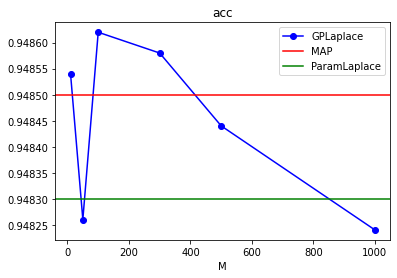

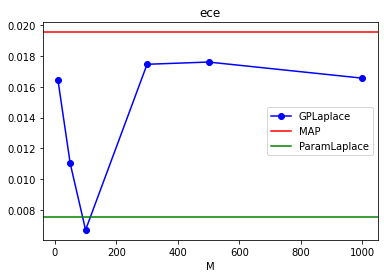

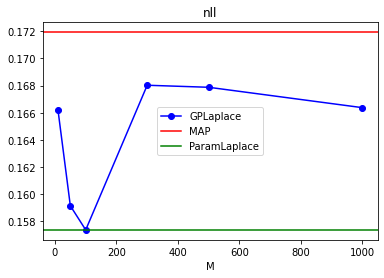

In [34]:
for metric in ["acc_laplace", "ece_laplace", "nll_laplace"]:
    metrics_gp.groupby(by="M")[[metric]].mean().rename({metric: "GPLaplace"}, axis=1).plot(style="-bo")
    plt.axhline(y=MAP_METRICS[metric[:3]], label="MAP", color="red")
    plt.axhline(y=PARAM_LAPLACE_METRICS[metric[:3]], label="ParamLaplace", color="green")
    plt.title(metric[:3])
    plt.legend()
    plt.show()